# Problem Statement

Given a past record of movies seen by a user, we will build a recommender system that helps the user discover movies of their interest.
Specifically, given <userID, itemID> occurrence pairs, we need to generate a ranked list of movies for each user.

State of the art algorithms for matrix factorization / emb-mat, and much more, can be easily replicated using neural networks.

## Movielens

In [1]:
import sys
!git clone https://github.com/yabhi0807/libml1.git /kaggle/tmp/fastai # This is my repo with all the fastai(updated) libraries 
sys.path.append('/kaggle/tmp/fastai')
!mkdir /kaggle/tmp/data/
!ln -s /kaggle/tmp/* /kaggle/working/

Cloning into '/kaggle/tmp/fastai'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 101 (delta 8), reused 0 (delta 0), pack-reused 83
Receiving objects: 100% (101/101), 466.52 KiB | 10.14 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

import warnings
warnings.filterwarnings("ignore")

In [3]:
!mkdir /kaggle/tmp/data/movies/
!cp -r ../input/movielenssp/* /kaggle/tmp/data/movies/
!ls /kaggle/tmp/data/movies/

movies.csv  ratings.csv


In [4]:
path='/kaggle/tmp/data/movies/'

In [5]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


Just for display purposes, let's read in the movie names too.

In [6]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,457,480,527,589,593,1196,1198,2571
userId,,,,,,,,,,,,,,,
62,2.0,3.0,3.0,2.5,5.0,4.5,4.0,1.0,3.0,5.0,4.0,4.5,3.0,1.0,1.5
63,NaN,4.5,3.0,4.5,3.5,4.0,4.5,3.0,3.0,NaN,3.5,3.5,5.0,4.0,5.0
128,3.0,5.0,4.5,3.5,5.0,5.0,4.5,4.0,3.5,3.5,3.5,4.0,4.0,4.0,4.0
224,4.5,5.0,4.0,3.5,4.5,5.0,5.0,4.0,4.5,4.0,4.5,4.0,4.5,4.0,4.5
232,3.5,NaN,4.0,4.0,4.5,4.0,4.0,4.5,3.5,NaN,4.5,4.0,4.0,5.0,4.5
310,3.0,4.0,4.0,3.0,4.0,4.5,3.5,4.0,3.0,4.0,4.5,3.5,3.5,3.0,4.0
413,4.0,2.5,NaN,4.0,4.5,5.0,4.0,NaN,5.0,4.0,4.0,3.5,4.0,4.0,5.0
451,3.5,4.5,4.0,4.5,4.5,4.0,NaN,4.0,4.0,NaN,4.0,5.0,4.0,4.5,3.5
458,3.5,5.0,5.0,4.5,5.0,4.0,4.0,4.0,2.0,5.0,5.0,5.0,4.5,5.0,5.0


## Evaluation Metrics

We use Mean-Square Error(MSE) to evaluate the performance for our Recommender System.

## Collaborative filtering

In [8]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')

In [9]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

## Models

### My Model

In [10]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50 # dimentionality of the embedding matrix

In [11]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

min_rating,max_rating = ratings.rating.min(),ratings.rating.max()

def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias_(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = torch.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res.view(-1, 1)

cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
model = EmbeddingDotBias_(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

fit(model, data, 3, opt, F.mse_loss)

set_lrs(opt, 1e-2)

fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      0.795895   0.785543  
    1      0.741717   0.765219  
    2      0.729218   0.760334  



epoch      trn_loss   val_loss   
    0      0.690832   0.752396  
    1      0.688473   0.751042  
    2      0.686106   0.750677  



[0.7506768925616516]

### Fastai Model

In [12]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [13]:
learn.fit(1e-2, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      0.74601    0.756632  
    1      0.742665   0.73658   
    2      0.597164   0.722251  
    3      0.733607   0.747648  
    4      0.659247   0.729003  
    5      0.566097   0.716688  
    6      0.418853   0.717275  



[0.7172748447681133]

Looking good!

In [14]:
preds = learn.predict()

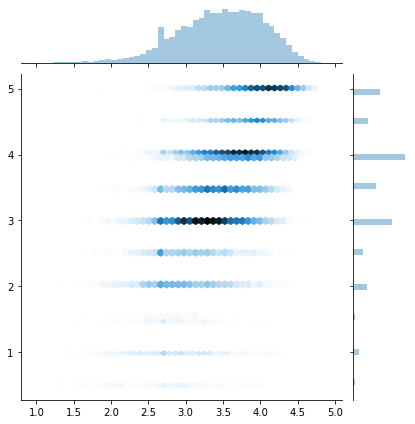

In [15]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Predictive Analysis 

### Movie bias

In [16]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(668, 50)
  (i): Embedding(10325, 50)
  (ub): Embedding(668, 1)
  (ib): Embedding(10325, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [17]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [18]:
movie_bias

array([[ 0.82617],
       [ 0.9039 ],
       [ 1.21164],
       ...,
       [-0.20065],
       [-0.00291],
       [ 0.09668]], dtype=float32)

In [19]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [20]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-1.1244253, 'Battlefield Earth (2000)'),
 (-0.9182625, 'Super Mario Bros. (1993)'),
 (-0.8267855, 'Police Academy 6: City Under Siege (1989)'),
 (-0.8239656, 'Speed 2: Cruise Control (1997)'),
 (-0.80927116, 'Showgirls (1995)'),
 (-0.8032202, 'Stop! Or My Mom Will Shoot (1992)'),
 (-0.7938442, 'Grease 2 (1982)'),
 (-0.77348864, 'Wild Wild West (1999)'),
 (-0.7678431, 'I Still Know What You Did Last Summer (1998)'),
 (-0.76340234, 'Catwoman (2004)'),
 (-0.7421684, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.71428686, 'Anaconda (1997)'),
 (-0.7065727, 'Barb Wire (1996)'),
 (-0.6923971, 'Mortal Kombat: Annihilation (1997)'),
 (-0.6811281, 'Flintstones in Viva Rock Vegas, The (2000)')]

In [21]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.2116449, 'Shawshank Redemption, The (1994)'),
 (1.0597835, 'Godfather, The (1972)'),
 (1.0252413, 'Usual Suspects, The (1995)'),
 (1.0087525, "Schindler's List (1993)"),
 (0.985322, 'Monty Python and the Holy Grail (1975)'),
 (0.9737719, 'Citizen Kane (1941)'),
 (0.9634583, 'Matrix, The (1999)'),
 (0.95129657, 'Silence of the Lambs, The (1991)'),
 (0.9493788, 'Fargo (1996)'),
 (0.92637116, 'Goodfellas (1990)'),
 (0.90389806, 'Forrest Gump (1994)'),
 (0.89487666, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.8864223, "One Flew Over the Cuckoo's Nest (1975)"),
 (0.8846516, 'Sixth Sense, The (1999)'),
 (0.8840405, 'Star Wars: Episode IV - A New Hope (1977)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [22]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [24]:
movie_pca.shape

(3, 3000)

In [25]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [26]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.085238464, 'Pulp Fiction (1994)'),
 (0.08428497, 'Clockwork Orange, A (1971)'),
 (0.08093001, 'Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)'),
 (0.0767241, 'Reservoir Dogs (1992)'),
 (0.06610708, 'Being John Malkovich (1999)'),
 (0.06610048, 'Apocalypse Now (1979)'),
 (0.06484788, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)'),
 (0.064068064, 'Shining, The (1980)'),
 (0.062300585, 'Full Metal Jacket (1987)'),
 (0.06020407, 'Taxi Driver (1976)')]

In [27]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.078861296, 'Armageddon (1998)'),
 (-0.072699994, 'First Knight (1995)'),
 (-0.06696479, 'Pretty Woman (1990)'),
 (-0.06684895, 'While You Were Sleeping (1995)'),
 (-0.0655757, 'Ghost (1990)'),
 (-0.065107405, 'Broken Arrow (1996)'),
 (-0.06510313, 'Pearl Harbor (2001)'),
 (-0.06398745, 'Net, The (1995)'),
 (-0.058995817, 'Cliffhanger (1993)'),
 (-0.058574, 'Batman & Robin (1997)')]

In [28]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'Hit' vs 'Not that impact'.

In [29]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.059391815, 'Johnny Mnemonic (1995)'),
 (0.058357053, 'Escape from L.A. (1996)'),
 (0.058232587, 'Adventures of Priscilla, Queen of the Desert, The (1994)'),
 (0.056227732, 'Barb Wire (1996)'),
 (0.055704262, 'Police Academy 6: City Under Siege (1989)'),
 (0.05502587, 'Toys (1992)'),
 (0.05000204, 'Godzilla (1998)'),
 (0.047982965, 'Solaris (Solyaris) (1972)'),
 (0.04660955, 'Congo (1995)'),
 (0.044690304, 'RoboCop 2 (1990)')]

In [30]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.1186391, 'Jurassic Park (1993)'),
 (-0.09505833, 'Aliens (1986)'),
 (-0.09293872, 'Terminator 2: Judgment Day (1991)'),
 (-0.09105156, 'Forrest Gump (1994)'),
 (-0.08916951, 'Die Hard (1988)'),
 (-0.08878745, 'Ben-Hur (1959)'),
 (-0.08058883, 'Back to the Future (1985)'),
 (-0.07819819, 'Top Gun (1986)'),
 (-0.07789384, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.077571526, 'Lord of the Rings: The Return of the King, The (2003)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

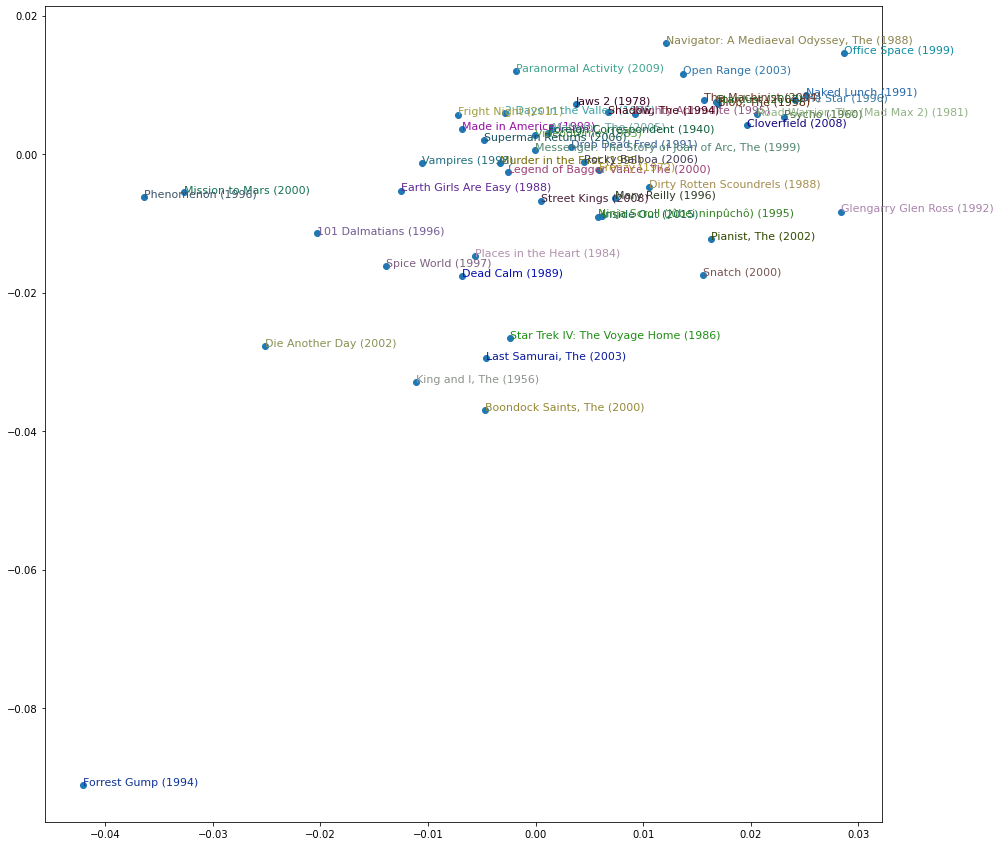

In [31]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Conclusion

We have successfully built a recommendation system using matrix factoring and neural nets.

There are many other ways in which a recommendation system can be built, the typical one these days use a lot of simulation techniques and extensive deep learning algorithms.

Happy Learning<br>
Cheerio!

# EOF